In [1]:
import sys,os
sys.path.append(os.curdir+"/deep-learning-from-scratch")
from dataset.mnist import load_mnist

import numpy as np
from PIL import Image
import matplotlib.pylab as plt

In [2]:
(x_train, t_train), (x_text, t_test) = load_mnist(normalize=True, one_hot_label=True)

In [3]:
t_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [4]:
def img_show(img):
    pil_img = Image.fromarray(np.uint8(img))
    pil_img.show()

In [5]:
def soft_max(a):
    c = np.max(a)
    exp_a = np.exp(a - c) # オーバーフロー対策
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    return y

In [6]:
img_show(x_train[0].reshape(28,28))

In [7]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + 1e-7)) / batch_size

In [8]:
x_train.shape[0]

60000

In [9]:
batch_size = 10
batch_mask = np.random.choice(x_train.shape[0], batch_size)
x_batch = x_train[batch_mask]
x_batch.shape[0]

10

In [10]:
# 数値微分 (中心差分)
def numerical_diff(f, x):
    h = 1e-4
    return (f(x+h)-f(x-h)) / (2*h)

In [11]:
function_1 = lambda x: 0.01 * x**2 + 0.1*x

numerical_diff(function_1, 5)

0.1999999999990898

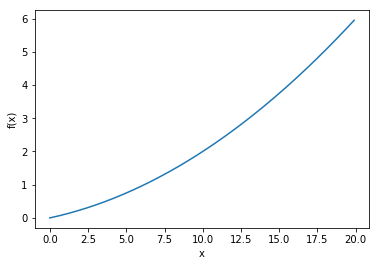

In [12]:
x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x, y)

In [13]:
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x) # same size of x filled by zero

    for idx in range(x.size):
        tmp_val = x[idx]
        
        # f(x+h)
        x[idx] = tmp_val + h
        fxh1 = f(x)

        # f(x-h)
        x[idx] = tmp_val - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val

    return grad

In [14]:
function_2 = lambda x: np.sum(x**2)

In [15]:
numerical_gradient(function_2, np.array([3.0, 4.0]))

array([6., 8.])

In [16]:
# 勾配降下法
def gradient_decent(f, init_x, lr=0.01, step_num=100):    
    x = init_x
    
    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad
    
    return x

In [17]:
init_x = np.array([-3.0, 4.0])
gradient_decent(function_2, init_x, lr=0.5, step_num=1000)

array([-2.91829320e-21, -2.44845461e-22])

In [18]:
class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3) # ガウス分布
    
    def predict(self, x):
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        z = self.predict(x)
        y = soft_max(z)
        loss = cross_entropy_error(y, t)
        
        return loss

In [19]:
net = simpleNet()
net.W

array([[-0.25641608,  0.32073725,  1.42023311],
       [ 0.30661752,  0.20897613, -0.33841708]])

In [20]:
x = np.array([0.6, 0.9])
p = net.predict(x)
np.argmax(p)

2

In [21]:
t = np.array([1,0,0]) # 正解ラベル
net.loss(x, t)

1.3416018661688334

In [22]:
def numerical_gradient2(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 値を元に戻す
        it.iternext()   
        
    return grad

In [23]:
f = lambda w: net.loss(x, t)
dW = numerical_gradient2(f, net.W)
dW

array([[-0.44314395,  0.2031088 ,  0.24003516],
       [-0.66471593,  0.30466319,  0.36005274]])

In [37]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [62]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 重みの初期化
        self.params = {}
        self.params["W1"] = weight_init_std * np.random.randn(input_size,hidden_size)
        self.params["b1"] = np.zeros(hidden_size)
        self.params["W2"] = weight_init_std * np.random.randn(hidden_size,output_size)
        self.params["b2"] = np.zeros(output_size)
    
    def predict(self, x):
        W1, W2 = self.params["W1"], self.params["W2"]
        b1, b2 = self.params["b1"], self.params["b2"]
        
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
    
    def loss(self, x, t):
        y = self.predict(x)
        loss = cross_entropy_error(y, t)
        
        return loss
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(x, axis=1)
        t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        grads = {}
        
        grads["W1"] = numerical_gradient2(loss_W, self.params["W1"])
        grads["b1"] = numerical_gradient2(loss_W, self.params["b1"])
        grads["W2"] = numerical_gradient2(loss_W, self.params["W2"])
        grads["b2"] = numerical_gradient2(loss_W, self.params["b2"])
        
        return grads

In [63]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
net.params["b1"].shape

(100,)

In [64]:
(x_train, t_train), (x_text, t_test) = load_mnist(normalize=True, one_hot_label=True)
train_loss_list = []

In [65]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x) # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x))

In [66]:
x = np.random.randn(100, 784)
t = np.random.randn(100, 10)

grads = net.numerical_gradient(x, t)
grads

{'W1': array([[ 1.30807452e-03, -2.78047803e-04,  6.71228004e-05, ...,
          8.22264999e-05, -9.35414066e-04, -2.05259158e-04],
        [ 6.66699184e-04,  4.40190451e-04,  1.15315759e-04, ...,
         -4.72721337e-04, -5.06232341e-04, -2.98074355e-04],
        [ 1.84643307e-04, -5.76055887e-04, -5.02940838e-04, ...,
          5.92349961e-05, -3.15619281e-04,  4.69829940e-04],
        ...,
        [-2.36210288e-04,  9.74779693e-05,  2.52938940e-04, ...,
         -4.69779727e-04, -4.58637476e-04,  4.75125481e-04],
        [ 5.91533652e-04,  6.34887174e-04,  2.07283303e-04, ...,
         -4.62359314e-04, -9.56923056e-04,  3.79728570e-04],
        [-1.05994964e-04, -6.98951765e-04,  2.68182323e-04, ...,
          1.63335843e-04,  4.32309985e-04, -1.78444248e-04]]),
 'W2': array([[ 3.42867174e-02, -2.66756118e-02,  3.75639287e-02,
         -1.35011086e-02,  2.18017589e-02, -2.12990513e-02,
          8.71938660e-02, -8.42986850e-02,  1.89065130e-02,
         -5.39783274e-02],
        [ 

In [60]:
# hyper parameter
iters_num = 10
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

network = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = network.numerical_gradient(x_batch, t_batch)
    
    for key in ("W1", "b1", "W2", "b2"):
        network.params[key] -= learning_rate * grad[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    print("i = %s" % i)
    print(loss)


train_loss_list

i = 0
6.886351890845256
i = 1
6.879043135525069
i = 2
6.895445417526195
i = 3
6.889694582937534
i = 4
6.89998483265997
i = 5
6.889568896001833
i = 6
6.898184811630631


KeyboardInterrupt: 